# Abstract

I have developed some working version and run it on oxford benchmark. Here I want to:

- Play with the thresholds
- Remove correspondences with negative similarity
- Find some pair which should have passed but did not
- _Scale change check in the verification_ (moved to 5th notebook)

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functools import partial
from itertools import cycle
from time import perf_counter
from tabulate import tabulate

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod, functional, hamming
from examples.demo_how import build_ivf, query_ivf

---

In [2]:
def get_packed_residuals(vecs, centroids, binary=True):
    residuals = vecs - centroids
    
    if binary:
        return hamming.binarize_and_pack_2D(residuals)
    else:
        return functional.normalize_vec_l2(residuals)

In [3]:
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m

In [4]:
def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm((hypotheses @ pts1) - pts2, axis=1)

In [5]:
def verify_single_model(errors, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask

In [6]:
def verify_models(errors, corrs, inlier_threshold=32):
    return np.apply_along_axis(
        partial(verify_single_model, corrs=corrs, inlier_threshold=inlier_threshold),
        axis=1,
        arr=errors,
    )

In [7]:
def affine_local_optimization(A, coordx1, coordy1, coordx2, coordy2):
    size = coordx1.size
    
    if size < 3:
        return A
    
    weight = 2 * np.pi if size < 11 else 0
    r2h = 50.0  # half of squared circle radius is integrated over
    
    mx1, my1 = coordx1.mean(), coordy1.mean()
    mx2, my2 = coordx2.mean(), coordy2.mean()
    
    dx1, dy1 = (coordx1 - mx1), (coordy1 - my1)
    dx2, dy2 = (coordx2 - mx2), (coordy2 - my2)
    
    # Compute AtA, AtB1, AtB2
    AtA = [0.0, 0.0, 0.0]
    AtB1 = [0.0, 0.0]
    AtB2 = [0.0, 0.0]
    
    AtA[0] = ((1 + weight) * dx1 * dx1 + weight * r2h).sum()
    AtA[1] = ((1 + weight) * dx1 * dy1).sum()
    AtA[2] = ((1 + weight) * dy1 * dy1 + weight * r2h).sum()
    
    AtB1[0] = ((1 + weight) * dx1 * dx2 + weight * A[0, 0] * r2h).sum()
    AtB1[1] = ((1 + weight) * dy1 * dx2 + weight * A[0, 1] * r2h).sum()
    
    AtB2[0] = ((1 + weight) * dx1 * dy2 + weight * A[1, 0] * r2h).sum()
    AtB2[1] = ((1 + weight) * dy1 * dy2 + weight * A[1, 1] * r2h).sum()
    
    # Final affine transformation
    detAtA = AtA[0] * AtA[2] - AtA[1] * AtA[1]
    if detAtA == 0:
        raise ValueError('Determinant equals to zero.')
        
    norm = 1 / detAtA
    H0 = (AtA[2] * AtB1[0] - AtA[1] * AtB1[1]) * norm
    H1 = (-AtA[1] * AtB1[0] + AtA[0] * AtB1[1]) * norm
    H2 = mx2 - mx1 * H0 - my1 * H1
    H3 = (AtA[2] * AtB2[0] - AtA[1] * AtB2[1]) * norm
    H4 = (-AtA[1] * AtB2[0] + AtA[0] * AtB2[1]) * norm
    H5 = my2 - mx1 * H3 - my1 * H4
    
    H = np.array([
        [H0, H1, H2],
        [H3, H4, H5],
        [0, 0, 1],
    ])
    
    return H

In [8]:
def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                    
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

---

In [9]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

In [10]:
# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

In [11]:
# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

ASMK INFO: All variables and logger set up


In [12]:
# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


In [13]:
metadata, images, ranks, _scores = asmk_dataset.query_ivf(desc['qvecs'], desc['qimids'])
compute_map_and_print(DATASET, ranks.T, gnd['gnd'])

>> roxford5k: mAP E: 94.75, M: 78.19, H: 55.51
>> roxford5k: mP@k[1, 5, 10] E: [100.    96.18  94.5 ], M: [100.    96.    92.86], H: [95.71 81.14 72.  ]


---

This was already done in `3-benchmark`, run it just to check everything is working.

In [18]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])

In [14]:
def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

In [15]:
t0 = perf_counter()
qvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['qvecs'], multiple_assignment=1)[1].ravel()
t1 = perf_counter()

(t1 - t0), qvecs_centroid_ids.shape

(2.8538884169993253, (69303,))

In [16]:
t0 = perf_counter()
# dbvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['vecs'], multiple_assignment=1)[1].ravel()
dbvecs_centroid_ids = np.load('desc_vecs-quantized-dbvecs_centroid_ids.npy')
t1 = perf_counter()

(t1 - t0), dbvecs_centroid_ids.shape

(0.012891250000393484, (4993000,))

In [17]:
t0 = perf_counter()

q_centroids = asmk_dataset.codebook.centroids[qvecs_centroid_ids]
db_centroids = asmk_dataset.codebook.centroids[dbvecs_centroid_ids]

q_residual_packs = get_packed_residuals(desc['qvecs'], q_centroids, binary=asmk_dataset.kernel.binary)
db_residual_packs = get_packed_residuals(desc['vecs'], db_centroids, binary=asmk_dataset.kernel.binary)

t1 = perf_counter()
(t1 - t0), q_residual_packs.shape, db_residual_packs.shape

(4.168968457999654, (69303, 4), (4993000, 4))

In [20]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

ranks_copy = ranks.copy()

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        best_hypothesis_index = verifications.sum(axis=1).argmax()
        
        A = hypotheses[best_hypothesis_index]
        mask = verifications[best_hypothesis_index]
        
        support = mask.sum()
        
        while True:
            new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
            errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            mask = verify_models(errors, corrs)[0]
            new_support = mask.sum()

            if new_support > support:
                support = new_support
                A = new_A
            else:
                break
        
        # Save the support
        supports[dbi] = support
    
    new_order = (-supports).argsort()
    ranks_copy[qi, :MAX_SPATIAL] = ranks[qi, new_order]
    
    
#  =========================
t1 = perf_counter()
t1 - t0

449.97419612500016

In [21]:
compute_map_and_print(DATASET, ranks_copy.T, gnd['gnd'])

>> roxford5k: mAP E: 88.02, M: 73.48, H: 48.51
>> roxford5k: mP@k[1, 5, 10] E: [98.53 90.15 86.75], M: [97.14 92.1  88.81], H: [85.71 70.67 64.38]


In [22]:
compute_map_and_print(DATASET, ranks.T, gnd['gnd'])

>> roxford5k: mAP E: 94.75, M: 78.19, H: 55.51
>> roxford5k: mP@k[1, 5, 10] E: [100.    96.18  94.5 ], M: [100.    96.    92.86], H: [95.71 81.14 72.  ]


---

Now try to find the best hypothesis which was modeled by a tentative correspondence with a negative similarity.

In [34]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

similarities_orders = []

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        # best_hypothesis_index = verifications.sum(axis=1).argmax()
        
        similarities_orders.append(similarities[(-verifications.sum(axis=1)).argsort()])
    
#  =========================
t1 = perf_counter()
t1 - t0

458.2370153340016

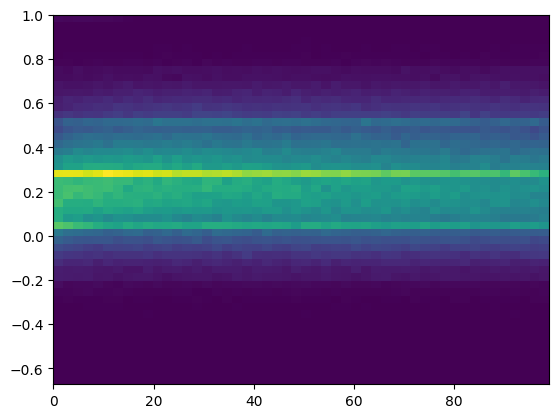

In [35]:
M = 100

hist_x = []
hist_y = []
for similarities in similarities_orders:
    data = similarities[:M]
    hist_x.extend(np.arange(len(data)))
    hist_y.extend(data)
    
plt.hist2d(hist_x, hist_y, bins=50)
plt.show()

In [40]:
np_hist_x = np.array(hist_x)
np_hist_y = np.array(hist_y)

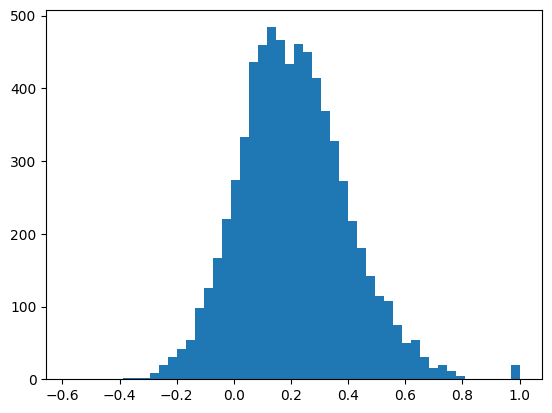

In [46]:
plt.hist(np_hist_y[np_hist_x == 0], bins=50)
plt.show()

---

Try to run the benchmark once again, this time with the "positive part of third power" metrics.

In [51]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

ranks_copy = ranks.copy()
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        best_hypothesis_index = ((verifications * _similarities[np.newaxis]) ** 3).sum(axis=1).argmax()
        
        A = hypotheses[best_hypothesis_index]
        mask = verifications[best_hypothesis_index]
        
        support = ((mask * _similarities) ** 3).sum()
        
        while True:
            new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
            errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            mask = verify_models(errors, corrs)[0]
            new_support = ((mask * _similarities) ** 3).sum()

            if new_support > support:
                support = new_support
                A = new_A
            else:
                break
        
        # Save the support
        supports[dbi] = support
    
    new_order = (-supports).argsort()
    ranks_copy[qi, :MAX_SPATIAL] = ranks[qi, new_order]
    
    
#  =========================
t1 = perf_counter()
t1 - t0

462.53126458300176

In [52]:
compute_map_and_print(DATASET, ranks_copy.T, gnd['gnd'])

>> roxford5k: mAP E: 88.34, M: 73.96, H: 50.04
>> roxford5k: mP@k[1, 5, 10] E: [97.06 90.88 87.37], M: [98.57 93.43 88.57], H: [90.   73.43 64.29]


In [53]:
compute_map_and_print(DATASET, ranks.T, gnd['gnd'])

>> roxford5k: mAP E: 94.75, M: 78.19, H: 55.51
>> roxford5k: mP@k[1, 5, 10] E: [100.    96.18  94.5 ], M: [100.    96.    92.86], H: [95.71 81.14 72.  ]


standard: 74.64

3rd pwer: 73.96

---

Try again the histogram of similarities used for hypotheses, this time with the best approach so far: simply weighted inliers.

In [54]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

similarities_orders = []

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        # best_hypothesis_index = (verifications * _similarities[np.newaxis]).sum(axis=1).argmax()
        
        scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
        similarities_orders.append(similarities[(-scores).argsort()])
    
#  =========================
t1 = perf_counter()
t1 - t0

452.5481524169991

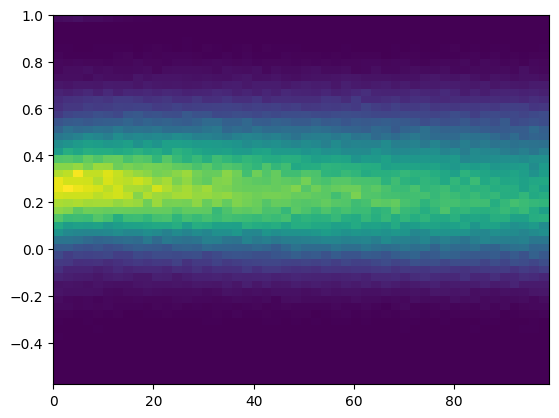

In [55]:
M = 100

hist_x = []
hist_y = []
for similarities in similarities_orders:
    data = similarities[:M]
    hist_x.extend(np.arange(len(data)))
    hist_y.extend(data)
    
plt.hist2d(hist_x, hist_y, bins=50)
plt.show()

In [56]:
np_hist_x = np.array(hist_x)
np_hist_y = np.array(hist_y)

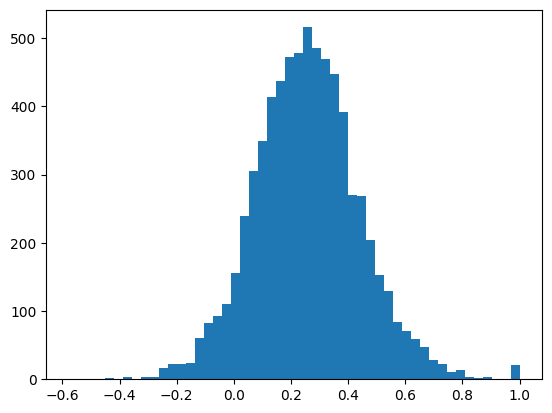

In [57]:
plt.hist(np_hist_y[np_hist_x == 0], bins=50)
plt.show()

---

Try the local optimization on multiple hypothesis and pick the best optimum.

In [62]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

ranks_copy = ranks.copy()
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])
lo_supports = []

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    image_lo_supports = []
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        _original_supports = (verifications * _similarities[np.newaxis]).sum(axis=1)
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_A = None

        im_db_lo_supp = []
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            mask = verifications[best_hypothesis_index]

            support = (mask * _similarities).sum()

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                mask = verify_models(errors, corrs)[0]
                new_support = (mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                else:
                    break

            im_db_lo_supp.append([_original_supports[best_hypothesis_index], support])
            
            if support > total_support:
                total_support = support
                total_A = A
                
        image_lo_supports.append(im_db_lo_supp)
        
        # Save the support
        supports[dbi] = total_support
    
    new_order = (-supports).argsort()
    ranks_copy[qi, :MAX_SPATIAL] = ranks[qi, new_order]
    lo_supports.append(image_lo_supports)
    
    
#  =========================
t1 = perf_counter()
t1 - t0

483.00331899999946

In [86]:
compute_map_and_print(DATASET, ranks_copy.T, gnd['gnd'])

>> roxford5k: mAP E: 90.59, M: 75.09, H: 51.01
>> roxford5k: mP@k[1, 5, 10] E: [97.06 92.94 89.26], M: [97.14 94.43 90.29], H: [91.43 75.86 66.43]


**We got better a little bit !!!**

In [79]:
best_model_positions = []

for qid in range(70):
    for dbid in range(100):
        stats = np.array(lo_supports[qid][dbid])
        
        am = stats.argmax(axis=0)
        best_model_positions.append(am[1])

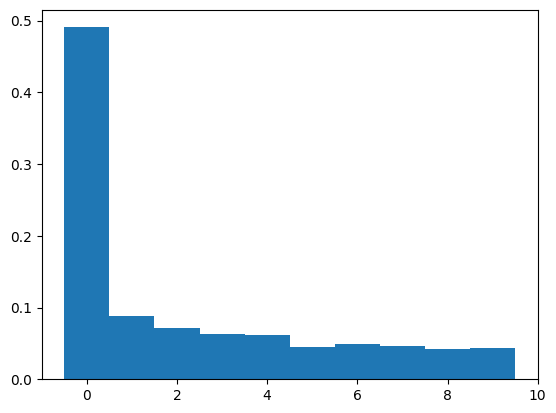

In [85]:
plt.hist(best_model_positions, range=(-0.5, 9.5), density=True)
plt.show()

---

This time we can try to adjust the thresholds.

In [91]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

ranks_copy = ranks.copy()
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])
lo_supports = []

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    image_lo_supports = []
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        _original_supports = (verifications * _similarities[np.newaxis]).sum(axis=1)
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_A = None

        im_db_lo_supp = []
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            # mask = verifications[best_hypothesis_index]
            
            mask = verify_single_model(errors[best_hypothesis_index], corrs, inlier_threshold=16)

            _os = (mask * _similarities).sum()
            support = _os

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                lo_errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                mask = verify_models(lo_errors, corrs, inlier_threshold=16)[0]
                new_support = (mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                else:
                    break

            im_db_lo_supp.append([_original_supports[best_hypothesis_index], _os, support])
            
            if support > total_support:
                total_support = support
                total_A = A
                
        image_lo_supports.append(im_db_lo_supp)
        
        # Save the support
        supports[dbi] = total_support
    
    new_order = (-supports).argsort()
    ranks_copy[qi, :MAX_SPATIAL] = ranks[qi, new_order]
    lo_supports.append(image_lo_supports)
    
    
#  =========================
t1 = perf_counter()
t1 - t0

496.52645375000066

In [92]:
compute_map_and_print(DATASET, ranks_copy.T, gnd['gnd'])

>> roxford5k: mAP E: 87.97, M: 73.75, H: 49.81
>> roxford5k: mP@k[1, 5, 10] E: [97.06 90.74 86.55], M: [98.57 93.57 89.29], H: [90.   72.14 64.29]


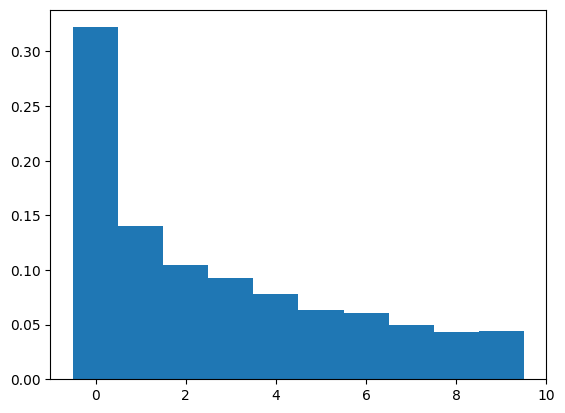

In [93]:
best_model_positions = []

for qid in range(70):
    for dbid in range(100):
        stats = np.array(lo_supports[qid][dbid])
        
        am = stats.argmax(axis=0)
        best_model_positions.append(am[1])
        
plt.hist(best_model_positions, range=(-0.5, 9.5), density=True)
plt.show()

---

Again the same (lower threshold for LO), but a bigger one this time.

In [94]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

ranks_copy = ranks.copy()
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])
lo_supports = []

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    image_lo_supports = []
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        _original_supports = (verifications * _similarities[np.newaxis]).sum(axis=1)
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_A = None

        im_db_lo_supp = []
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            # mask = verifications[best_hypothesis_index]
            
            mask = verify_single_model(errors[best_hypothesis_index], corrs, inlier_threshold=24)

            _os = (mask * _similarities).sum()
            support = _os

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                lo_errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                mask = verify_models(lo_errors, corrs, inlier_threshold=24)[0]
                new_support = (mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                else:
                    break

            im_db_lo_supp.append([_original_supports[best_hypothesis_index], _os, support])
            
            if support > total_support:
                total_support = support
                total_A = A
                
        image_lo_supports.append(im_db_lo_supp)
        
        # Save the support
        supports[dbi] = total_support
    
    new_order = (-supports).argsort()
    ranks_copy[qi, :MAX_SPATIAL] = ranks[qi, new_order]
    lo_supports.append(image_lo_supports)
    
    
#  =========================
t1 = perf_counter()
t1 - t0

493.3227802500005

In [95]:
compute_map_and_print(DATASET, ranks_copy.T, gnd['gnd'])

>> roxford5k: mAP E: 89.66, M: 74.61, H: 50.49
>> roxford5k: mP@k[1, 5, 10] E: [97.06 92.06 88.68], M: [97.14 93.57 89.29], H: [90.   74.43 65.71]


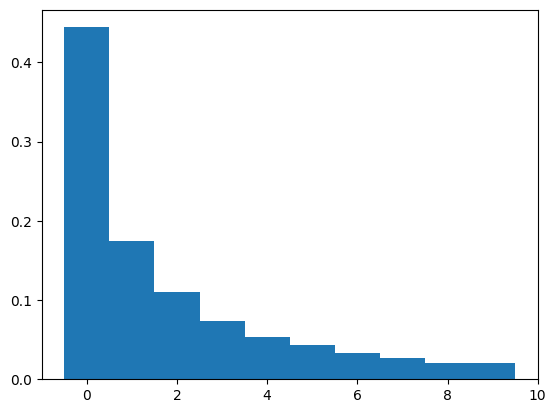

In [96]:
best_model_positions = []

for qid in range(70):
    for dbid in range(100):
        stats = np.array(lo_supports[qid][dbid])
        
        am = stats.argmax(axis=0)
        best_model_positions.append(am[1])
        
plt.hist(best_model_positions, range=(-0.5, 9.5), density=True)
plt.show()

---

Take the best hyperparameters so far and try to evaluate them with tentative correspondences with negative similarities removed.

In [98]:
def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                
                #
                # Here is the change
                #
                mask = (mask & (cross_product_similarities > 0))
                
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

In [105]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100

ranks_copy = ranks.copy()
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])
lo_supports = []

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    image_lo_supports = []
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        if not corrs.size:
            print(f'No correspondences for: qi={qi}, dbi={dbi}')
            image_lo_supports.append([])
            supports[dbi] = 0
            continue
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        _original_supports = (verifications * _similarities[np.newaxis]).sum(axis=1)
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_A = None

        im_db_lo_supp = []
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            mask = verifications[best_hypothesis_index]

            support = (mask * _similarities).sum()

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                mask = verify_models(errors, corrs)[0]
                new_support = (mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                else:
                    break

            im_db_lo_supp.append([_original_supports[best_hypothesis_index], support])
            
            if support > total_support:
                total_support = support
                total_A = A
                
        image_lo_supports.append(im_db_lo_supp)
        
        # Save the support
        supports[dbi] = total_support
    
    new_order = (-supports).argsort()
    ranks_copy[qi, :MAX_SPATIAL] = ranks[qi, new_order]
    lo_supports.append(image_lo_supports)
    
    
#  =========================
t1 = perf_counter()
t1 - t0

No correspondences for: qi=64, dbi=68


442.371511041998

In [106]:
compute_map_and_print(DATASET, ranks_copy.T, gnd['gnd'])

>> roxford5k: mAP E: 90.57, M: 75.06, H: 50.92
>> roxford5k: mP@k[1, 5, 10] E: [97.06 92.94 89.85], M: [98.57 94.71 90.43], H: [92.86 76.14 66.29]


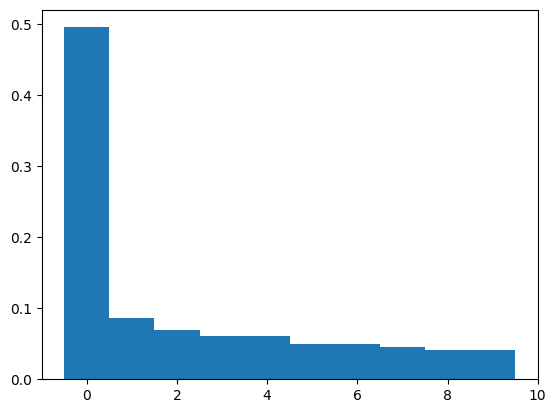

In [108]:
best_model_positions = []

for qid in range(70):
    for dbid in range(100):
        if not lo_supports[qid][dbid]:
            continue
        stats = np.array(lo_supports[qid][dbid])
        
        am = stats.argmax(axis=0)
        best_model_positions.append(am[1])
        
plt.hist(best_model_positions, range=(-0.5, 9.5), density=True)
plt.show()

---

Try to find a correct pair which does not satisfy the spatial verification.

In [244]:
#
# Get back to original tentative correspondences
#
def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

In [256]:
t0 = perf_counter()

results = {
    'qi': [],
    'dbi': [],
    'num_of_corrs': [],
    'num_of_inliers': [],
    'score': [],
}
for qi in range(len(gnd['gnd'])):
    
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    for dbi in gnd['gnd'][qi]['easy']:
        
        dbl = np.searchsorted(desc['imids'], dbi, 'left')
        dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        if not corrs.size:
            results['qi'].append(qi)
            results['dbi'].append(dbi)
            results['num_of_corrs'].append(0)
            results['num_of_inliers'].append(0)
            results['score'].append(0)
            continue
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best models
        _original_supports = (verifications * _similarities[np.newaxis]).sum(axis=1)
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_noi = -1
        total_A = None
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            mask = verifications[best_hypothesis_index]

            support = (mask * _similarities).sum()
            noi = mask.sum()

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                mask = verify_models(errors, corrs)[0]
                new_support = (mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                    noi = mask.sum()
                else:
                    break
            
            if support > total_support:
                total_support = support
                total_A = A
                total_noi = noi
                
        # Save the support
        results['qi'].append(qi)
        results['dbi'].append(dbi)
        results['num_of_corrs'].append(corrs.shape[0])
        results['num_of_inliers'].append(total_noi)
        results['score'].append(total_support)

t1 = perf_counter()
t1 - t0

460.0189830419986

In [257]:
print(tabulate({
    "qi": results['qi'],
    "qname": [gnd['qimlist'][i] for i in results['qi']],
    "dbi": results['dbi'],
    "dbname": [gnd['imlist'][i] for i in results['dbi']],
    "num_of_corrs": results['num_of_corrs'],
    "num_of_inliers": results['num_of_inliers'],
    "score": results['score'],
}, headers="keys"))

  qi  qname                      dbi  dbname                     num_of_corrs    num_of_inliers       score
----  -----------------------  -----  -----------------------  --------------  ----------------  ----------
   0  all_souls_000013            30  all_souls_000153                    313                31    8.65625
   0  all_souls_000013            69  all_souls_000126                    693                88   32.4531
   0  all_souls_000013           296  all_souls_000055                    734               107   39.8125
   0  all_souls_000013           324  oxford_000130                       566                75   27.9531
   0  all_souls_000013           581  all_souls_000091                    634                76   25.5156
   0  all_souls_000013           623  all_souls_000073                    414                41   13.5156
   0  all_souls_000013           685  oxford_000177                       268                28    8.23438
   0  all_souls_000013           691  al

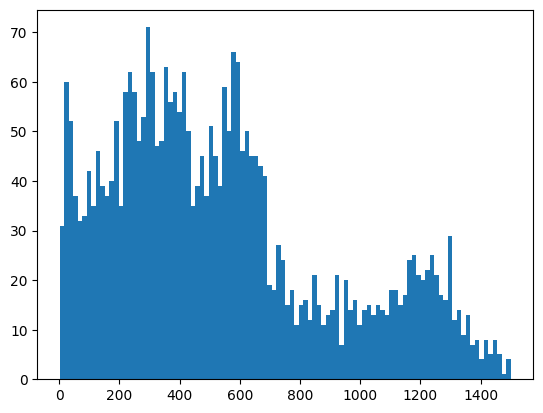

In [258]:
plt.hist(results['num_of_corrs'], bins=100)
plt.show()

---

Plot corrs...

In [165]:
def plot_corrs(qimg, dbimg, qbbx=None, qx=None, qy=None, qs=None, dbx=None, dby=None, dbs=None):
    plt.figure(figsize=(12, 12))
    qh, qw, _ = qimg.shape
    dbh, dbw, _ = dbimg.shape
    
    img = np.zeros([max(qh, dbh), qw + dbw, 3], dtype=int)
    img[:qh, :qw] = qimg
    img[:dbh, qw:] = dbimg
    
    scales = [2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25]
    bbx, bby, *_ = qbbx if qbbx is not None else [0, 0]
    
    if all(i is not None for i in [qx, qy, qs, dbx, dby, dbs]):
        for x1, y1, s1, x2, y2, s2, c in zip(qx, qy, qs, dbx, dby, dbs, cycle(mcolors.TABLEAU_COLORS.values())):
            plt.plot(
                [int((x1 * 16 / scales[s1]) + bbx), int(x2 * 16 / scales[s2]) + qw],
                [int((y1 * 16 / scales[s1]) + bby), int(y2 * 16 / scales[s2])],
                color=c,
                marker='o',
                linestyle='dashed',
                linewidth=1,
                markersize=3,
            )
    
    plt.imshow(img)
    plt.show()

In [166]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'

In [259]:
qi = 1
dbi = 3458

query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
qbbx = gnd['gnd'][qi]['bbx']

In [263]:
ql = np.searchsorted(desc['qimids'], qi, 'left')
qr = np.searchsorted(desc['qimids'], qi, 'right')

q_coordx = desc['qcoordx'][ql:qr]
q_coordy = desc['qcoordy'][ql:qr]
q_scales = desc['qscales'][ql:qr]
q_centroid_ids = qvecs_centroid_ids[ql:qr]
q_residuals = q_residual_packs[ql:qr]

dbl = np.searchsorted(desc['imids'], dbi, 'left')
dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
db_coordx = desc['coordx'][dbl:dbr]
db_coordy = desc['coordy'][dbl:dbr]
db_scales = desc['scales'][dbl:dbr]
db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
db_residuals = db_residual_packs[dbl:dbr]

corrs = corrs, similarities = get_tentative_correspondencies(
    q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
)

In [264]:
corrs.shape

(204, 2)

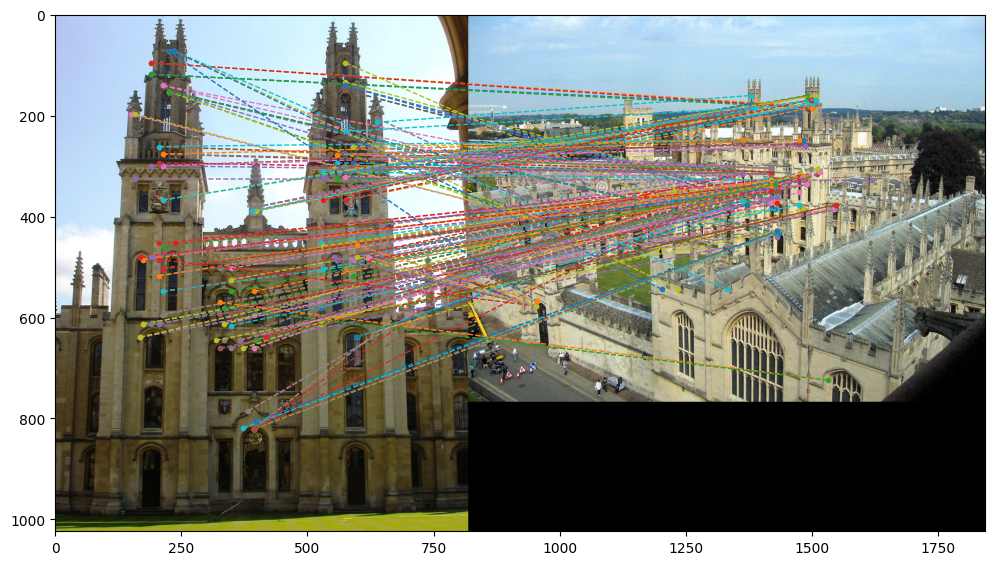

In [265]:
plot_corrs(
    query_img,
    result_img,
    qbbx=qbbx,
    qx=q_coordx[corrs[:, 0]],
    qy=q_coordy[corrs[:, 0]],
    qs=q_scales[corrs[:, 0]],
    dbx=db_coordx[corrs[:, 1]],
    dby=db_coordy[corrs[:, 1]],
    dbs=db_scales[corrs[:, 1]],
)

(130, 2)


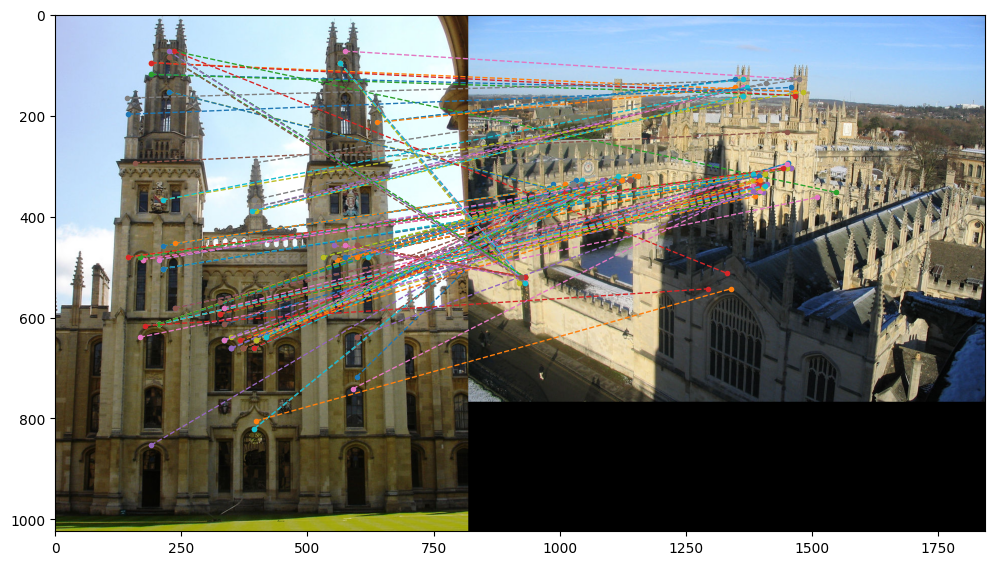

In [277]:
qi = 1
dbi = 4236

query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
qbbx = gnd['gnd'][qi]['bbx']

############

ql = np.searchsorted(desc['qimids'], qi, 'left')
qr = np.searchsorted(desc['qimids'], qi, 'right')

q_coordx = desc['qcoordx'][ql:qr]
q_coordy = desc['qcoordy'][ql:qr]
q_scales = desc['qscales'][ql:qr]
q_centroid_ids = qvecs_centroid_ids[ql:qr]
q_residuals = q_residual_packs[ql:qr]

dbl = np.searchsorted(desc['imids'], dbi, 'left')
dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
db_coordx = desc['coordx'][dbl:dbr]
db_coordy = desc['coordy'][dbl:dbr]
db_scales = desc['scales'][dbl:dbr]
db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
db_residuals = db_residual_packs[dbl:dbr]

corrs = corrs, similarities = get_tentative_correspondencies(
    q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
)
print(corrs.shape)

############

plot_corrs(
    query_img,
    result_img,
    qbbx=qbbx,
    qx=q_coordx[corrs[:, 0]],
    qy=q_coordy[corrs[:, 0]],
    qs=q_scales[corrs[:, 0]],
    dbx=db_coordx[corrs[:, 1]],
    dby=db_coordy[corrs[:, 1]],
    dbs=db_scales[corrs[:, 1]],
)